# __Group 5 DSCI 100 Project__

## Introduction

### Background information:
- Research conducted by UBC research group, Pacific Laboratory for Artificial Intelligence
- Data was collected through minecraft server
- Goal of creating an AI able to understand speech, and respond in a complex virtual environment

### Research Question
- "Can the status of subscribing to a game-related newsletter be predicted from age and hours played?"

### players.csv:
- The players dataframe has 196 observations, with 7 variables
- This gives information on the demographics of players who log onto PLAI's minecraft server

| Variable | Description | Data type |
|----------|-------------|-----------|
| experience | Self-identifying Level of Experience | chr|
| subscribe  | Game Newsletter Subscription Status | lgl |
| hashedEmail | Hashed Version of Player Email | chr |
| played_hours | Hours spent in game | dbl |
| name | Name of player | chr |
| gender | Gender of player | chr |
| age | Age of player | dbl |

**Summary of Quantitative Variables**

| Variable | Min | Max | Mean |
|----------|-----|-----|------|
| played_hours | 0.00 | 223.10 | 5.85|
|age | 9.00 | 58.00 | 21.14 |

There is a large spread of values for played values, with a maximum of 223, but a mean of 5.85; this can be presented as an outlier value.

## Methods

##### Loading in libraries and datasets

In [1]:
library(tidyverse)
library(tidymodels)
players_info <- read_csv('data/players.csv')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

##### Tidy and wrangling data

In [20]:
tidy_players_info <- players_info |>
    mutate(subscribe = as.factor(subscribe)) |>
    mutate(experience = as.factor(experience)) |>
    filter(na.rm = TRUE) |>
    filter(!is.na(Age)) |>
    select(subscribe, played_hours, Age)
head(tidy_players_info) 

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


##### Distribution of data

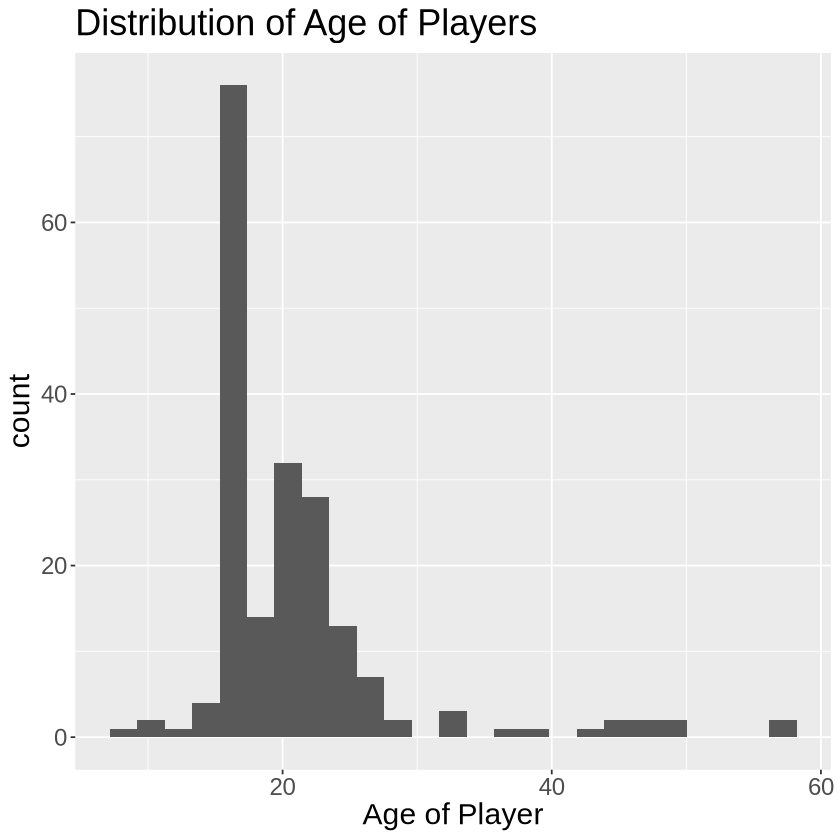

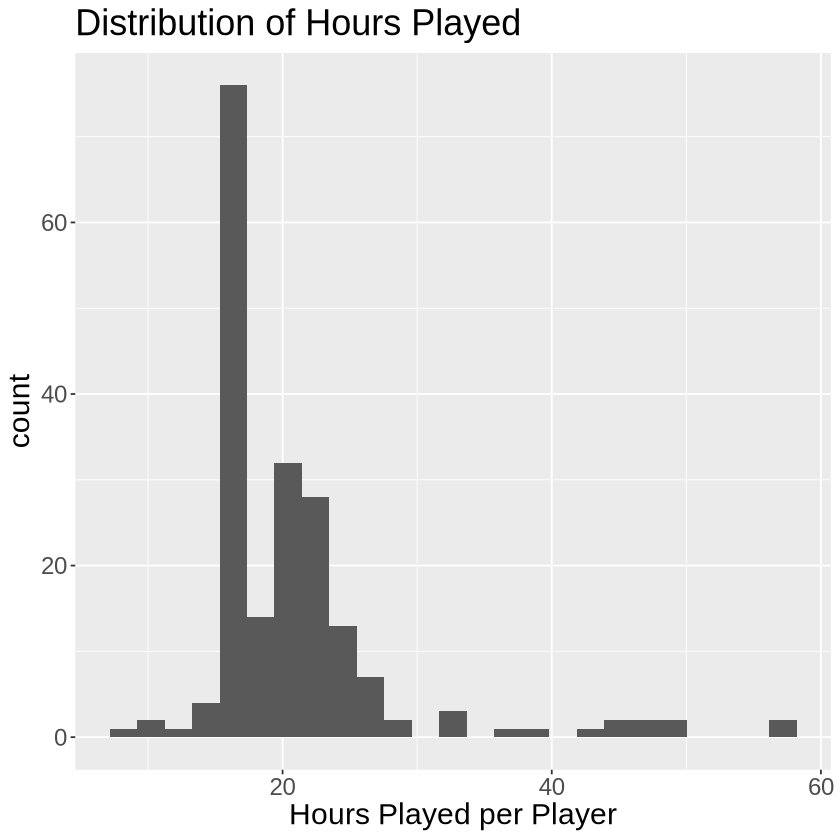

In [21]:
age_distribution <- tidy_players_info |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 25) +
    labs(x = 'Age of Player', title = 'Distribution of Age of Players') +
    theme(text = element_text(size = 18))

played_hours_distribution <- tidy_players_info |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 25) +
    labs(x = 'Hours Played per Player', title = 'Distribution of Hours Played') +
    theme(text = element_text(size = 18))

age_distribution
played_hours_distribution

## Results

##### Splitting Data

In [22]:
player_split <- initial_split(tidy_players_info, prop = 0.75, strata = subscribe)  
player_train <- training(player_split)   
player_test <- testing(player_split)

##### Building K-NN Classification Model

In [23]:
player_recipe <- recipe(subscribe ~ played_hours + Age, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

player_fit <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_spec) |>
      fit(data = player_train)

Warning message:
“tune samples were requested but there were 145 rows in the data. 140 will be used.”


##### Tuning K

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 29 rows.
               ✖ Assigned data has 30 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 30 to size 29.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





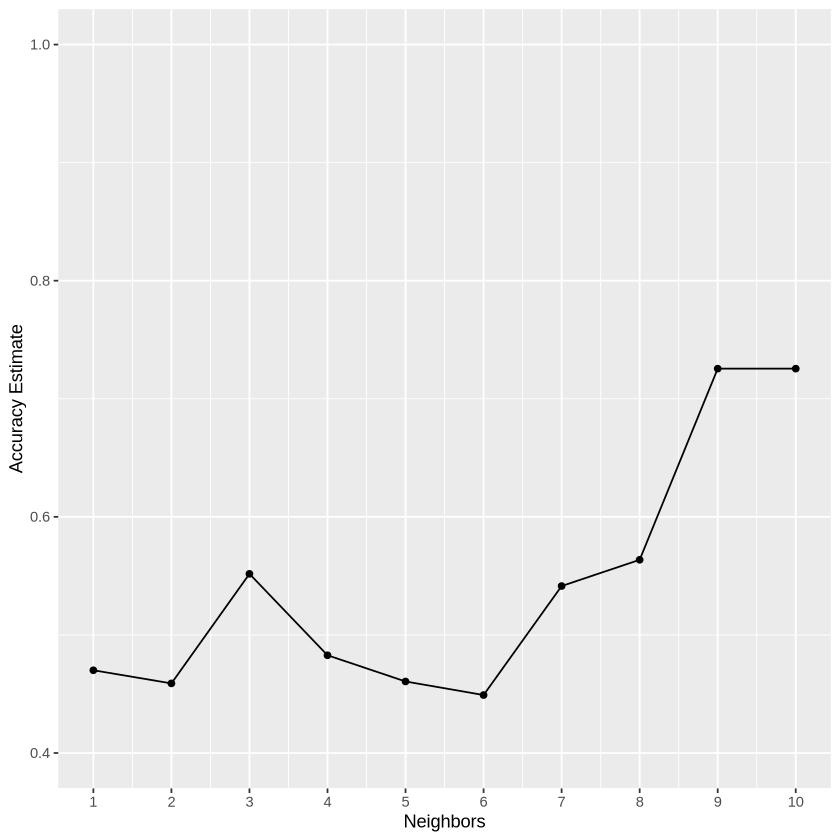

In [9]:
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_knn_results <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_spec) |>
      tune_grid(resamples = player_vfold, grid = k_vals) |>
      collect_metrics()

accuracies <- player_knn_results |> 
      filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) + # 
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
cross_val_plot

# EXPLAIN WHY K = 9 WAS CHOSEN

##### Building Model with K = 9

In [10]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

player_fit <- workflow() |>
      add_recipe(player_recipe) |>
      add_model(player_spec) |>
      fit(data = player_train)

##### Applying Model to Testing Set

In [11]:
player_predictions <- predict(player_fit, player_test) |>
                        bind_cols(player_test)
head(player_predictions)

player_metrics <- player_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class)

player_conf_matrix <- player_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
player_metrics
player_conf_matrix

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,FALSE,0.0,17
TRUE,TRUE,0.0,17
TRUE,TRUE,48.4,17
TRUE,TRUE,0.0,17
FALSE,FALSE,0.1,18
TRUE,TRUE,0.4,20


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7959184
kap,binary,0.3059490


          Truth
Prediction FALSE TRUE
     FALSE     3    0
     TRUE     10   36

##### Plotting Data Analysis

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


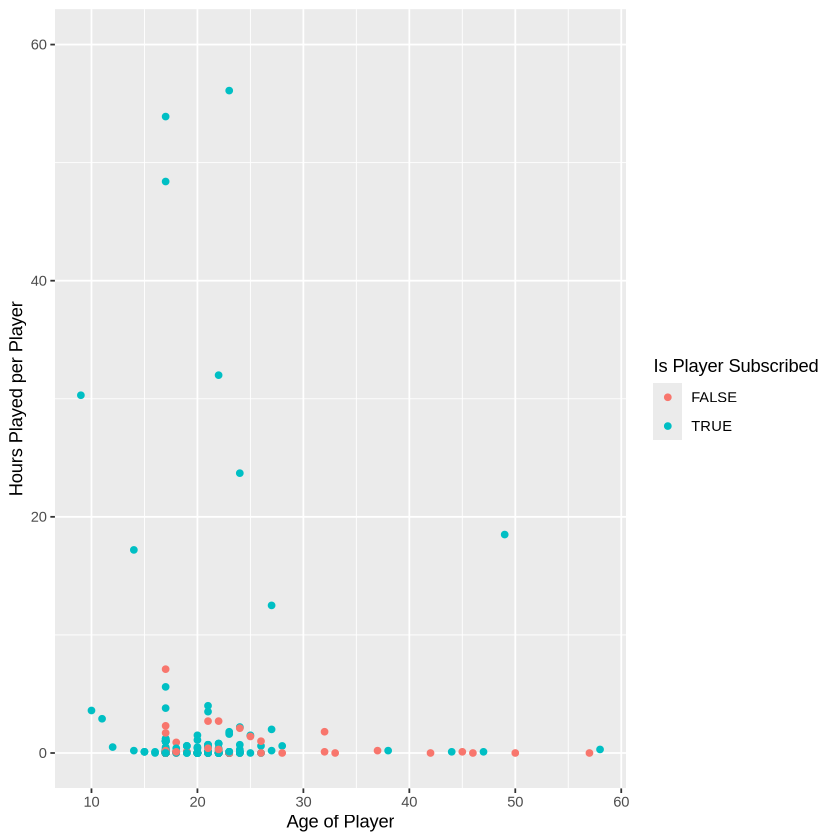

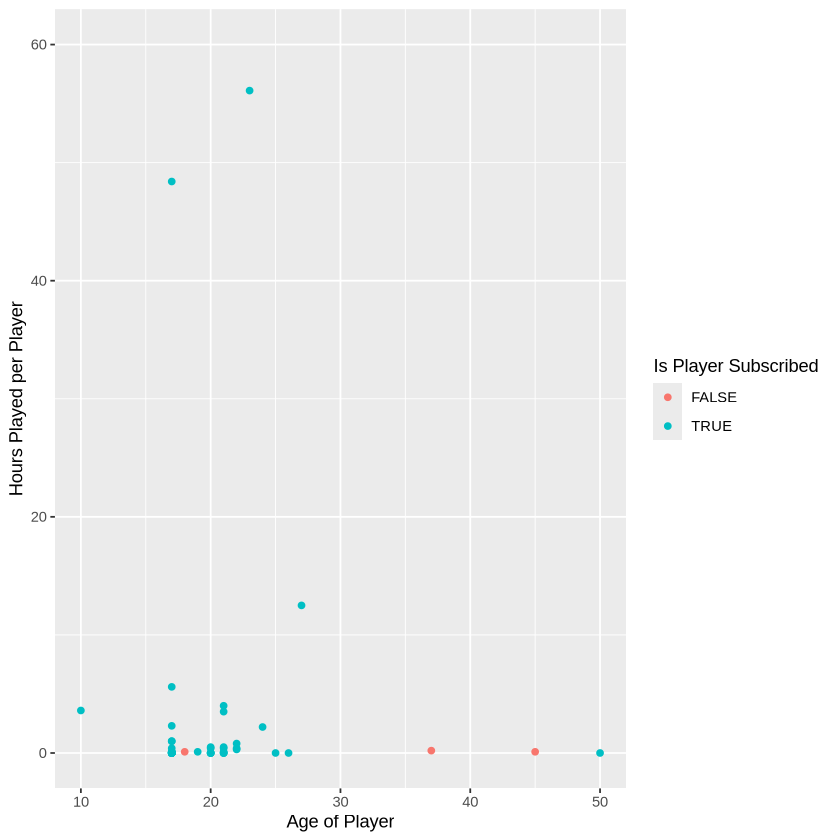

In [13]:
age_vs_played_hours <- tidy_players_info |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(x = 'Age of Player', y = 'Hours Played per Player', color = 'Is Player Subscribed') +
    ylim(0, 60) 
age_vs_played_hours

age_vs_played_hours_1 <- player_predictions |>
    ggplot(aes(x = Age, y = played_hours, color = .pred_class)) +
    geom_point() +
    labs(x = 'Age of Player', y = 'Hours Played per Player', color = 'Is Player Subscribed') +
    ylim(0, 60) 
age_vs_played_hours_1

## Discussion

- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to